<div id="container" style="position:relative;">
<div style="position:center; float:left"><h1>03 - CryptoPunk Price Prediction <br>Model Construction </h1></div>
<div style="position:relative; float:right"> 

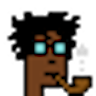</div>

Madelyn Goodman <br>
Brainstation Winter 2022 Capstone <br>
April 4, 2022

# Introduction


In the previous notebook, 02-CryptoPunk Price Prediction EDA, I performed several analyses including different data visualizations and initial linear regression analyses. These linear regressions did not prove to be well fit with R2s between 0.03 and 0.1. This performance provides a good justification to explore more non-linear models to represent characteristics of punk sales to their ultimate sale price. 

In this notebook, I performed a gird search of a Decision Tree Regressor, Ridge Regression, and a Support Vector Regression in order to find the best supervised learning model to compare a deep learning model to in order to ensure that I was selecting the model that fit the data the best. 

I then tested 14 different architectures of neural networks. I evaluated these using and R2 score and observing loss trends to tweak the models to prevent overfitting. 
<hr>

In [ ]:
# importing packages

#setting seeds
#setting a seed value 
seed_value = 789

#setting the PYTHONHASHSEED environment variable to be fixed
import os
#making an environment variable to access from anywhere
os.environ['PYTHONHASHSEED']=str(seed_value)

#setting the python built-in random generator to be fixed
import random
random.seed(seed_value)

#setting numpy random generator to be fixed
import numpy as np
np.random.seed(seed_value)

#setting tensorflow random generator to be fixed 
import tensorflow as tf
tf.random.set_seed(seed_value)

#configuring a global tensorflow session 
from tensorflow import keras
from tensorflow.keras import layers
!pip install -U tensorflow-addons
from tensorflow.python.keras.metrics import Metric
import tensorflow_addons as tfa
#ensuring code is not running on GPU, as this can insert randomness
CUDA_VISIBLE_DEVICES=""

#importing other base packages
import pandas as pd

import matplotlib.pyplot as plt

#importing supervised learning packages
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

#installing and importing joblib
!pip install joblib
import joblib

In [ ]:
#loading cleaned data
cp_sales = pd.read_csv('Data/punk_sales_data.csv')

In [ ]:
#viewing data
pd.set_option('display.max_columns', None)
cp_sales.head()

,Unnamed: 0,txn_type,date,source,eth,punk_id,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,cap,cap forward,chinstrap,choker,cigarette,classic shades,clown eyes blue,clown eyes green,clown hair green,clown nose,cowboy hat,crazy hair,dark hair,do-rag,earring,eye mask,eye patch,fedora,front beard,front beard dark,frown,frumpy hair,goat,gold chain,green eye shadow,half shaved,handlebars,headband,hoodie,horned rim glasses,hot lipstick,knitted cap,luxurious beard,medical mask,messy hair,mohawk,mohawk dark,mohawk thin,mole,mustache,muttonchops,nerd glasses,normal beard,normal beard black,orange side,peak spike,pigtails,pilot helmet,pink with hat,pipe,police cap,purple eye shadow,purple hair,purple lipstick,red mohawk,regular shades,rosy cheeks,shadow beard,shaved head,silver chain,small shades,smile,spots,straight hair,straight hair blonde,straight hair dark,stringy hair,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,alien,ape,female,male,zombie,punk_rarity,larvalabs,opensea,price_delta
0,0,Sold,2017-06-23,larvalabs,0.98,0,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207,1,0,0.98
1,1,Sold,2017-06-23,larvalabs,0.00,544,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.347835,1,0,0.00
2,2,Sold,2017-06-23,larvalabs,0.25,1841,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.566622,1,0,0.25
3,3,Sold,2017-06-23,larvalabs,0.00,3134,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.324392,1,0,0.00
4,4,Sold,2017-06-23,larvalabs,0.06,4025,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.321051,1,0,0.06


# Cleaning data for modeling 

In [ ]:
#dropping unamed column
cp_sales.drop('Unnamed: 0', inplace=True, axis=1)
cp_sales.head()

,txn_type,date,source,eth,punk_id,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,cap,cap forward,chinstrap,choker,cigarette,classic shades,clown eyes blue,clown eyes green,clown hair green,clown nose,cowboy hat,crazy hair,dark hair,do-rag,earring,eye mask,eye patch,fedora,front beard,front beard dark,frown,frumpy hair,goat,gold chain,green eye shadow,half shaved,handlebars,headband,hoodie,horned rim glasses,hot lipstick,knitted cap,luxurious beard,medical mask,messy hair,mohawk,mohawk dark,mohawk thin,mole,mustache,muttonchops,nerd glasses,normal beard,normal beard black,orange side,peak spike,pigtails,pilot helmet,pink with hat,pipe,police cap,purple eye shadow,purple hair,purple lipstick,red mohawk,regular shades,rosy cheeks,shadow beard,shaved head,silver chain,small shades,smile,spots,straight hair,straight hair blonde,straight hair dark,stringy hair,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,alien,ape,female,male,zombie,punk_rarity,larvalabs,opensea,price_delta
0,Sold,2017-06-23,larvalabs,0.98,0,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207,1,0,0.98
1,Sold,2017-06-23,larvalabs,0.00,544,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.347835,1,0,0.00
2,Sold,2017-06-23,larvalabs,0.25,1841,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.566622,1,0,0.25
3,Sold,2017-06-23,larvalabs,0.00,3134,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.324392,1,0,0.00
4,Sold,2017-06-23,larvalabs,0.06,4025,326.99,0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.321051,1,0,0.06


In [ ]:
#checking null values 
cp_sales.isna().sum().sum()

0

In [ ]:
#checking for duplicated rows 
cp_sales.duplicated().sum().sum()

0

In [ ]:
#sorting by date and punk
cp_sales.sort_values(['punk_id', 'date'], ascending=(True, True), inplace=True, ignore_index=True)
cp_sales.head()

,txn_type,date,source,eth,punk_id,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,cap,cap forward,chinstrap,choker,cigarette,classic shades,clown eyes blue,clown eyes green,clown hair green,clown nose,cowboy hat,crazy hair,dark hair,do-rag,earring,eye mask,eye patch,fedora,front beard,front beard dark,frown,frumpy hair,goat,gold chain,green eye shadow,half shaved,handlebars,headband,hoodie,horned rim glasses,hot lipstick,knitted cap,luxurious beard,medical mask,messy hair,mohawk,mohawk dark,mohawk thin,mole,mustache,muttonchops,nerd glasses,normal beard,normal beard black,orange side,peak spike,pigtails,pilot helmet,pink with hat,pipe,police cap,purple eye shadow,purple hair,purple lipstick,red mohawk,regular shades,rosy cheeks,shadow beard,shaved head,silver chain,small shades,smile,spots,straight hair,straight hair blonde,straight hair dark,stringy hair,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,alien,ape,female,male,zombie,punk_rarity,larvalabs,opensea,price_delta
0,Sold,2017-06-23,larvalabs,0.98,0,326.99,0,0.00,0,0.00,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207,1,0,0.98
1,Sold,2017-07-07,larvalabs,1.60,0,241.28,9,3.71,1,0.98,14,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207,1,0,0.62
2,Sold,2018-11-30,larvalabs,25.00,0,111.65,1,1.60,2,1.60,525,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207,1,0,23.40
3,Sold,2017-06-26,larvalabs,0.42,1,252.99,4,0.23,0,0.00,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.337443,1,0,0.42
4,Sold,2019-04-06,larvalabs,31.00,1,165.79,4,1.38,1,0.42,652,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.337443,1,0,30.58


In [ ]:
#checking that the dates were sorted properly
cp_sales.tail()

,txn_type,date,source,eth,punk_id,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,cap,cap forward,chinstrap,choker,cigarette,classic shades,clown eyes blue,clown eyes green,clown hair green,clown nose,cowboy hat,crazy hair,dark hair,do-rag,earring,eye mask,eye patch,fedora,front beard,front beard dark,frown,frumpy hair,goat,gold chain,green eye shadow,half shaved,handlebars,headband,hoodie,horned rim glasses,hot lipstick,knitted cap,luxurious beard,medical mask,messy hair,mohawk,mohawk dark,mohawk thin,mole,mustache,muttonchops,nerd glasses,normal beard,normal beard black,orange side,peak spike,pigtails,pilot helmet,pink with hat,pipe,police cap,purple eye shadow,purple hair,purple lipstick,red mohawk,regular shades,rosy cheeks,shadow beard,shaved head,silver chain,small shades,smile,spots,straight hair,straight hair blonde,straight hair dark,stringy hair,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,alien,ape,female,male,zombie,punk_rarity,larvalabs,opensea,price_delta
18938,Sold,2020-09-27,larvalabs,59.00,9997,357.55,6,10.13,0,0.0,1192,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.935381,1,0,59.00
18939,Sold,2021-02-08,larvalabs,99.99,9997,1752.98,1,0.00,1,59.0,1326,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.935381,1,0,40.99
18940,Sold,2020-12-27,larvalabs,15.00,9998,684.12,0,0.00,0,0.0,1283,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.579769,1,0,15.00
18941,Sold,2021-03-03,larvalabs,38.00,9998,1567.86,1,30.00,1,15.0,1349,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.579769,1,0,23.00
18942,Sold,2021-08-11,larvalabs,110.00,9998,3162.61,2,34.00,2,38.0,1510,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.579769,1,0,72.00


In [ ]:
#defining variables to drop that won't work in the model
todrop_model = ['txn_type', 'date', 'source', 'punk_id', 'larvalabs', 'opensea', 'price_delta']

In [ ]:
#dropping variables
cp_sales_model = cp_sales.drop(todrop_model, axis=1)
cp_sales_model.head()

,eth,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,cap,cap forward,chinstrap,choker,cigarette,classic shades,clown eyes blue,clown eyes green,clown hair green,clown nose,cowboy hat,crazy hair,dark hair,do-rag,earring,eye mask,eye patch,fedora,front beard,front beard dark,frown,frumpy hair,goat,gold chain,green eye shadow,half shaved,handlebars,headband,hoodie,horned rim glasses,hot lipstick,knitted cap,luxurious beard,medical mask,messy hair,mohawk,mohawk dark,mohawk thin,mole,mustache,muttonchops,nerd glasses,normal beard,normal beard black,orange side,peak spike,pigtails,pilot helmet,pink with hat,pipe,police cap,purple eye shadow,purple hair,purple lipstick,red mohawk,regular shades,rosy cheeks,shadow beard,shaved head,silver chain,small shades,smile,spots,straight hair,straight hair blonde,straight hair dark,stringy hair,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,alien,ape,female,male,zombie,punk_rarity
0,0.98,326.99,0,0.00,0,0.00,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207
1,1.60,241.28,9,3.71,1,0.98,14,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207
2,25.00,111.65,1,1.60,2,1.60,525,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461207
3,0.42,252.99,4,0.23,0,0.00,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.337443
4,31.00,165.79,4,1.38,1,0.42,652,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.337443


# Supervised learning analysis

<hr>

## GridSearch and Piping - Price

<hr>

Testing supervised models first with a grid search. I wanted to get an idea of how the data responded to a machine learning model and the type of accuracy and predictions to compare the neural networks against. 

I decided to do a grid search as it is the industry standard for finding the best fitting model and set of parameters. 

I first split and scaled the data. I decided to scale the data as Ridge and SVR regressions respond best to scaled data. I used a StandardScaler as to not restrict future input data transformed with the scaler to be within the confines of the minimum and maximum of the training data. 
<hr>

In [ ]:
#prepping data
#splitting feature and target
X = cp_sales_model.drop('eth', axis=1)
y = cp_sales_model['eth']
print(X.shape)
print(y.shape)

#testing and validtion split  
from sklearn.model_selection import train_test_split

#test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=789)
#validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=789)

#scaling 
from sklearn.preprocessing import StandardScaler
cp_scaler = StandardScaler()
cp_scaler.fit(X_train)

X_train_s = cp_scaler.transform(X_train)
X_validation_s = cp_scaler.transform(X_validation)
X_test_s = cp_scaler.transform(X_test)

(18943, 101)
(18943,)


In [ ]:
#setting up grid and pipeline

#just testing the different models against eachother and their associated parameters
#not testing different scalers etc
estimators = [('model', DecisionTreeRegressor())]

pipe = Pipeline(estimators)

#putting together the param grid 
param_grid = [
    {#Decision tree
        'model':[DecisionTreeRegressor()],
        'model__max_depth': [1,3,5,7,9]
    },
    {#Ridge regression
        'model': [Ridge()],
        'model__alpha': [1, 10, 100, 1000],
        'model__solver': ['auto', 'lsqr']
    },
    {#Support vector regressor
        'model': [SVR()],
        'model__C': [0.001, 0.1, 1, 10, 100],
        'model__epsilon': [0.001, 0.1, 1, 10, 100]
    }
]

<hr>

I decided to set cross validation of the GridSearch to 3 to save some runtime. 
<hr>

In [ ]:
#setting up the grid 
grid = GridSearchCV(pipe, param_grid, cv=3)

#fitting the grid
fittedgrid = grid.fit(X_train, y_train)

In [ ]:
#optimal model
fittedgrid.best_estimator_

Pipeline(steps=[('model', DecisionTreeRegressor(max_depth=9))])

In [ ]:
#accuracy
fittedgrid.score(X_test, y_test)

0.7866840997257052

<hr>

The decision tree regressor with a max depth of 9 was the best fitting model. The model predicted the data with 78.67% accuracy. Because the Decision Tree Regressor was the best model, I decided to also run a Random Forest Regressor using the optimal max depth found here. I chose to also run this model as a Random forest can show better accuracy than a Decision Tree Regressor as it randomly runs several different models and averages out the scores. 
<hr>

## Random Forest Regressor

<hr>

I decided to use 50 estimators as for the sake of time, I did not run a parameter selection process but this seemed like a reasonable number of random trees to test. 

This model was fit and scored on unscaled data, as scaling is not required for this type of model.
<hr>

In [ ]:
#instantiating the model 
RF_model = RandomForestRegressor(max_depth=9, n_estimators=50, random_state=789)

#fitting the model
RF_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_estimators=50, random_state=789)

In [ ]:
#scoring the model
RF_model.score(X_validation, y_validation)

0.8425749346947695

<hr>

Unsurprisingly, the random forest model out performed the Decision Tree Regressor from the grid search with and R2 of 0.84. This model will be saved and compared to the best neural network in the following notebook. 
<hr>

In [ ]:
#saving the random forest model 

joblib.dump(RF_model, 'generated_files/RandomForest_model.pkl')

['/content/drive/MyDrive/Brainstation/Capstone/MBG_Capstone_Code/RandomForest_model.pkl']

# Neural network building

<hr>

I decided to explore neural network models to predict prices of CryptoPunks as well. Neural networks are generally regarded as the most robust of the machine learning modeling techniques, so I was motivated that I could build a model that would be able to predict prices with high accuracy. 

As this problem was one of predicting a continuous value, I used relu activation functions throughout and scored my models using R2, a measure of how well the model fits the data. 

The number of nodes tested in each layer were inspired by the features of the data. There were 101 total features, therefore, I started with layers with this many nodes. As I added and removed layers further I used layers with 87 nodes, the number of attributes of punks, 5 layers, the number of types of punks, 92 layers, the number of types and attributes together, and 9, the number of numeric features. 

As I scored models through these iterations of the model, I only considered models that had an R2 of 0.65 or greater for final model selection, where accuracy was further evaluated and compared between models in notebook #. 
<hr>

In [ ]:
#prepping data
#splitting feature and target
X = cp_sales_model.drop('eth', axis=1)
y = cp_sales_model['eth']
print(X.shape)
print(y.shape)

#testing and validtion split  
from sklearn.model_selection import train_test_split

#test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=789)
#validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=789)

#scaling 
from sklearn.preprocessing import StandardScaler
cp_scaler = StandardScaler()
cp_scaler.fit(X_train)

X_train_s = cp_scaler.transform(X_train)
X_validation_s = cp_scaler.transform(X_validation)
X_test_s = cp_scaler.transform(X_test)

(18943, 101)
(18943,)


In [ ]:
#looking at the training features
X_train.head()

,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,cap,cap forward,chinstrap,choker,cigarette,classic shades,clown eyes blue,clown eyes green,clown hair green,clown nose,cowboy hat,crazy hair,dark hair,do-rag,earring,eye mask,eye patch,fedora,front beard,front beard dark,frown,frumpy hair,goat,gold chain,green eye shadow,half shaved,handlebars,headband,hoodie,horned rim glasses,hot lipstick,knitted cap,luxurious beard,medical mask,messy hair,mohawk,mohawk dark,mohawk thin,mole,mustache,muttonchops,nerd glasses,normal beard,normal beard black,orange side,peak spike,pigtails,pilot helmet,pink with hat,pipe,police cap,purple eye shadow,purple hair,purple lipstick,red mohawk,regular shades,rosy cheeks,shadow beard,shaved head,silver chain,small shades,smile,spots,straight hair,straight hair blonde,straight hair dark,stringy hair,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,alien,ape,female,male,zombie,punk_rarity
14788,370.69,1,2.40,1,2.40,1185,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.338279
13541,2463.90,1,50.00,1,50.00,1498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.340152
1677,406.46,4,5.81,1,0.08,1220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.350982
18700,1852.00,3,0.65,1,1.35,1335,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.447256
18314,1040.00,2,0.16,0,0.00,216,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.428765


## Model 1 - simplest architecture 

<hr>

Going to start building a neural network with a simple architecture and build up. The data has 101 features, so will use this number of nodes as a starting point. 

There are no published neural network architectures looking at predicting NFT prices, therefore, I had to start my exploration from scratch. I started testing with a simple model, then a more complex model to see how the data would react, then tuned from there. 

There are 87 attributes, 5 types, and 9 other variables, which will all be considered for number of nodes as well. 
<hr>

In [ ]:
#first model with just one hidden layer

#create a sequential model 
model_1 = keras.Sequential()

#creating one hidden layer
model_1.add(layers.Dense(101, activation='relu'))

#declaring the output layer 
model_1.add(layers.Dense(1))

#compile the model 
model_1.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#started with 50 epochs as it was a modest number to build from 
history_1 = model_1.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 1s 2ms/step - loss: 2766.5098 - val_loss: 1596.7343
Epoch 2/50
474/474 [==============================] - 1s 2ms/step - loss: 1679.0038 - val_loss: 1241.3234
Epoch 3/50
474/474 [==============================] - 1s 2ms/step - loss: 1434.6311 - val_loss: 1167.7190
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 1319.1958 - val_loss: 1170.3718
Epoch 5/50
474/474 [==============================] - 1s 2ms/step - loss: 1262.5372 - val_loss: 1218.9298
Epoch 6/50
474/474 [==============================] - 1s 2ms/step - loss: 1213.3624 - val_loss: 1269.4340
Epoch 7/50
474/474 [==============================] - 1s 2ms/step - loss: 1174.2899 - val_loss: 1257.3197
Epoch 8/50
474/474 [==============================] - 1s 2ms/step - loss: 1146.8937 - val_loss: 1274.5455
Epoch 9/50
474/474 [==============================] - 1s 2ms/step - loss: 1116.8389 - val_loss: 1286.8169
Epoch 10/50
474/474 [=========================

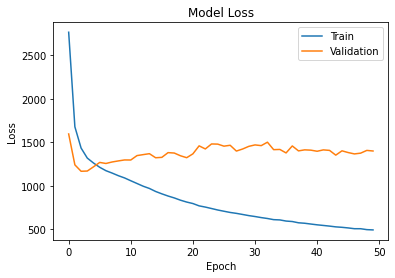

In [ ]:
#plot loss against number of epochs to check for overfitting
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

This model looks pretty overfit, the validation loss remains high as the training loss consistently goes down.
<hr>

In [ ]:
#checking the train and validation loss
train_loss_1 = history_1.history['loss'][-1]
result_1 = model_1.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_1: .4f}')
print(f'Validation loss: {result_1: .4f}')


Train loss:  493.2348
Validation loss:  1400.8513


In [ ]:
#scoring the model looking at the R2
y_pred_1 = model_1.predict(X_validation_s)

from sklearn.metrics import r2_score

r2_score(y_validation, y_pred_1)

0.5104970213751686

<hr>

The r2 here is a really good starting point. When it comes to predicting price, having 51% accuracy is generally considered really good - this is a great point to build from. From the graph of epochs to losses it's clear that the model is slightly overfit, however. Next will test an architecture that is much more complicated as a comparison to see which way to go in the model building process. 
<hr>

## Model 2 - complicated architecture 

In [ ]:
#Second model - adding layers based on number of attributes and extra first layer
#throwing in dropout

#create a sequential model 
model_2 = keras.Sequential()

#creating hidden layers
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_2.add(layers.Dense(87, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(9, activation='relu'))
model_2.add(layers.Dense(5, activation='relu'))

#declaring the output layer 
model_2.add(layers.Dense(1))

#compile the model 
model_2.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_2 = model_2.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 4ms/step - loss: 1968.9980 - val_loss: 1188.4053
Epoch 2/50
474/474 [==============================] - 2s 3ms/step - loss: 1546.1107 - val_loss: 1248.4752
Epoch 3/50
474/474 [==============================] - 2s 3ms/step - loss: 1311.7759 - val_loss: 1745.2490
Epoch 4/50
474/474 [==============================] - 2s 4ms/step - loss: 1256.5453 - val_loss: 1396.8538
Epoch 5/50
474/474 [==============================] - 2s 3ms/step - loss: 1193.8425 - val_loss: 2382.6819
Epoch 6/50
474/474 [==============================] - 2s 3ms/step - loss: 1077.8185 - val_loss: 3308.7468
Epoch 7/50
474/474 [==============================] - 2s 3ms/step - loss: 1051.5120 - val_loss: 1573.4135
Epoch 8/50
474/474 [==============================] - 2s 3ms/step - loss: 1047.1476 - val_loss: 1398.6019
Epoch 9/50
474/474 [==============================] - 1s 3ms/step - loss: 883.0280 - val_loss: 1401.7255
Epoch 10/50
474/474 [==========================

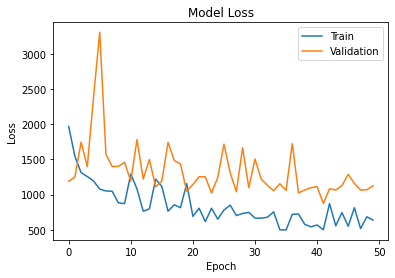

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The loss appears to have converged well between the training and validation sets without too large of a gap. Once reason for this might be because I included dropout layers between the layers with a greater number of nodes. These will randomly dropout nodes as the model runs to reduce overfitting. Since this worked well for this model, I decided to use this strategy going forward with the rest of the models after layers with many nodes.
<hr>

In [ ]:
#checking on the loss of the training and validation data
train_loss_2 = history_2.history['loss'][-1]
result_2 = model_2.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_2: .4f}')
print(f'Validation loss: {result_2: .4f}')


Train loss:  636.3659
Validation loss:  1124.4688


In [ ]:
#scoring the model 
y_pred_2 = model_2.predict(X_validation_s)

r2_score(y_validation,y_pred_2)

0.6070741223803576

<hr>

This model performed much better than the simpler architecture above. As I continued to revise the architecture of the model, I started here and began paring down, as the more complex architecture proved to provide more accuracy.

Since this model performed well and the comparison of the training and validation loss did not indicate too much overfitting, I decided to test the model running for 100 epochs with an early stopping callback specifying a patience of 10. This set the model to stop training if the validation loss was not reduced after 10 training runs of the model to reduce overfitting and save runtime. 
<hr>

### Model 2 with 100 epochs

In [ ]:
#training model 2 with more epochs

#create a sequential model 
model_2 = keras.Sequential()

#creating hidden layers
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(101, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_2.add(layers.Dense(87, activation='relu'))
model_2.add(layers.Dropout(rate=0.25))
model_2.add(layers.Dense(9, activation='relu'))
model_2.add(layers.Dense(5, activation='relu'))

#declaring the output layer 
model_2.add(layers.Dense(1))

#compile the model 
model_2.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError())

In [ ]:
#running model - trying 100 epochs to see if there is any improvement 
callback = callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_2_100 = model_2.fit(X_train_s, y_train, epochs=100, verbose=1, validation_data=(X_validation_s, y_validation), 
                            callbacks=[callback])

Epoch 1/100
474/474 [==============================] - 3s 4ms/step - loss: 1842.4994 - val_loss: 1191.2855
Epoch 2/100
474/474 [==============================] - 2s 5ms/step - loss: 1548.0159 - val_loss: 1213.2677
Epoch 3/100
474/474 [==============================] - 2s 5ms/step - loss: 1380.6704 - val_loss: 1336.2349
Epoch 4/100
474/474 [==============================] - 3s 6ms/step - loss: 1514.2163 - val_loss: 1198.7449
Epoch 5/100
474/474 [==============================] - 3s 6ms/step - loss: 1188.1853 - val_loss: 3145.1382
Epoch 6/100
474/474 [==============================] - 2s 4ms/step - loss: 1204.6759 - val_loss: 1533.2312
Epoch 7/100
474/474 [==============================] - 3s 7ms/step - loss: 900.5741 - val_loss: 1230.5148
Epoch 8/100
474/474 [==============================] - 4s 8ms/step - loss: 1097.7358 - val_loss: 1258.2097
Epoch 9/100
474/474 [==============================] - 3s 5ms/step - loss: 1261.4598 - val_loss: 1253.1853
Epoch 10/100
474/474 [================

<hr>

The early stopping callback stopped the model training after 40 epochs, fewer than specified above. 
<hr>

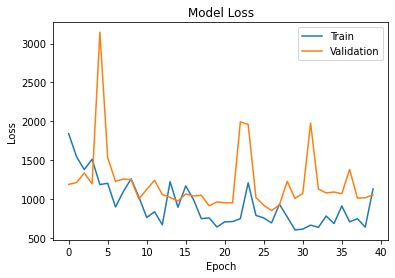

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_2_100.history['loss'])
plt.plot(history_2_100.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

This plot shows that this model was not subject to overfitting as the training adn validation loss remain close throughout the training process. 
<hr>

In [ ]:
#checking on the loss of the training and validation data
train_loss_2_100 = history_2_100.history['loss'][-1]
result_2_100 = model_2.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_2_100: .4f}')
print(f'Validation loss: {result_2_100: .4f}')

#scoring the model 
y_pred_2_100 = model_2.predict(X_validation_s)

print(r2_score(y_validation, y_pred_2_100))

Train loss:  1131.8359
Validation loss:  1056.5645
0.6308020327600661


<hr>

This model did improve its accuracy after running it with the callback function. This model would be a candidate to test for final model evaluation. 
<hr>

## Model 3 - slimming down complicated model

<hr>

After working with model 2, a more complicated architecture, I wanted to see if better accuracy lay in the middle ground between models 1 and 2, so I started playing with removing and reordering the layers in model 2 as well as including batch normalization into the model to see if it would improve model performance and reduce overfitting. 
<hr>

In [ ]:
#Third model- cutting down the extra 101 layers and adding batch normalization under the dropout

#create a sequential model 
model_3 = keras.Sequential()

#creating hidden layers
model_3.add(layers.Dense(101, activation='relu'))
model_3.add(layers.Dropout(rate=0.25))
model_3.add(layers.BatchNormalization())

#layers of the number of different feature types
model_3.add(layers.Dense(87, activation='relu'))
model_3.add(layers.Dropout(rate=0.25))
model_3.add(layers.BatchNormalization())

model_3.add(layers.Dense(9, activation='relu'))
model_3.add(layers.Dense(5, activation='relu'))

#declaring the output layer 
model_3.add(layers.Dense(1))

#compile the model 
model_3.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_3 = model_3.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 3ms/step - loss: 2437.0281 - val_loss: 1151.2577
Epoch 2/50
474/474 [==============================] - 1s 3ms/step - loss: 1754.0516 - val_loss: 1160.6683
Epoch 3/50
474/474 [==============================] - 1s 3ms/step - loss: 1668.5031 - val_loss: 1467.0403
Epoch 4/50
474/474 [==============================] - 1s 3ms/step - loss: 1631.4178 - val_loss: 1265.4745
Epoch 5/50
474/474 [==============================] - 1s 3ms/step - loss: 1534.7378 - val_loss: 2602.9966
Epoch 6/50
474/474 [==============================] - 1s 3ms/step - loss: 1458.6439 - val_loss: 3251.4768
Epoch 7/50
474/474 [==============================] - 1s 3ms/step - loss: 1443.4000 - val_loss: 4933.8101
Epoch 8/50
474/474 [==============================] - 1s 3ms/step - loss: 1295.1412 - val_loss: 15129.2598
Epoch 9/50
474/474 [==============================] - 1s 3ms/step - loss: 1243.9674 - val_loss: 38776.0742
Epoch 10/50
474/474 [=======================

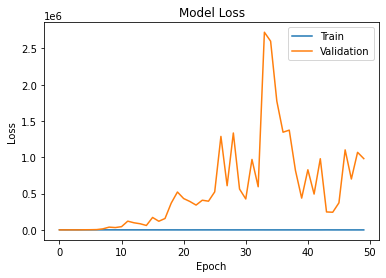

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The loss between the training and validation data started out very similar but then ended up diverging a lot. This indicates that this model was quite overfit. It appears that the losses are similar at the beginning because of the scale of the validation loss, as the model ran, the validation data experienced growing loss.
<hr>

In [ ]:
#checking the validation and train loss 
train_loss_3 = history_3.history['loss'][-1]
result_3 = model_3.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_3: .4f}')
print(f'Validation loss: {result_3: .4f}')


Train loss:  526.8250
Validation loss:  982372.1875


In [ ]:
#scoring the model with R2
y_pred_3 = model_3.predict(X_validation_s)

r2_score(y_validation, y_pred_3)

-342.27261571326

<hr>

This negative R2 score indicates that the model is much less accurate than a simple straight line. This architecture was very inappropriate to fit the data. It seems that I slimmed the architecture of model 2 too much so I tried to add another layer in. It is also possible that the data did not respond well to the inclusion of batch normalization, however, since this method is often used, I decided to try it again in the next model but only after the layers with 101 nodes. 
<hr>

## Model 4 - trying to add another layer to the slimmer model

In [ ]:
#Model 4

#create a sequential model 
model_4 = keras.Sequential()

#creating hidden layers
model_4.add(layers.Dense(101, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(101, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())

#layers of the number of different feature types - adding dropout and normalization
model_4.add(layers.Dense(87, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(9, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(5, activation='relu'))

#declaring the output layer 
model_4.add(layers.Dense(1))

#compile the model 
model_4.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_4 = model_4.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 58s 4ms/step - loss: 3491.0171 - val_loss: 2781.2253
Epoch 2/50
474/474 [==============================] - 2s 4ms/step - loss: 2432.3145 - val_loss: 1823.9890
Epoch 3/50
474/474 [==============================] - 2s 4ms/step - loss: 2119.5405 - val_loss: 1685.3202
Epoch 4/50
474/474 [==============================] - 2s 4ms/step - loss: 2056.0657 - val_loss: 1645.0004
Epoch 5/50
474/474 [==============================] - 2s 3ms/step - loss: 2022.8812 - val_loss: 1603.9677
Epoch 6/50
474/474 [==============================] - 2s 4ms/step - loss: 2002.9468 - val_loss: 1564.9661
Epoch 7/50
474/474 [==============================] - 2s 4ms/step - loss: 2005.4186 - val_loss: 1553.8458
Epoch 8/50
474/474 [==============================] - 2s 4ms/step - loss: 1964.9323 - val_loss: 1545.4709
Epoch 9/50
474/474 [==============================] - 2s 3ms/step - loss: 1969.5516 - val_loss: 1563.9250
Epoch 10/50
474/474 [========================

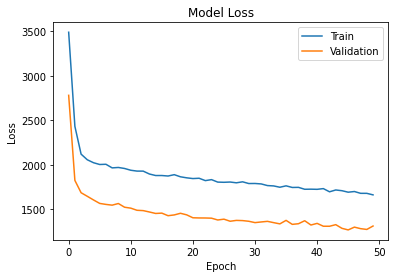

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The train and validation loss never get close to converging, indicating that this model's architecture lends itself to overfitting and will probably not be a good candidate.
<hr>

In [ ]:
#checking the training and validation loss
train_loss_4 = history_4.history['loss'][-1]
result_4 = model_4.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_4: .4f}')
print(f'Validation loss: {result_4: .4f}')


Train loss:  1661.1809
Validation loss:  1310.6749


In [ ]:
#scoring the model with R2
y_pred_4 = model_4.predict(X_validation_s)

r2_score(y_validation, y_pred_4)

0.5420076086878589

<hr>

Actually somewhat of an improvement from model 1. Since this model had a higher score than expected, I decided to run it with 100 epochs with an early stop call back function with patience 10 to see if this would prevent overfitting. 
<hr>

### Model 4 with 100 epochs

In [ ]:
#Model 4

#create a sequential model 
model_4 = keras.Sequential()

#creating hidden layers
model_4.add(layers.Dense(101, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(101, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())

#layers of the number of different feature types - adding dropout and normalization
model_4.add(layers.Dense(87, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(9, activation='relu'))
model_4.add(layers.Dropout(rate=0.25))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(5, activation='relu'))

#declaring the output layer 
model_4.add(layers.Dense(1))

#compile the model 
model_4.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model with more epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_4_100 = model_4.fit(X_train_s, y_train, epochs=100, verbose=1, validation_data=(X_validation_s, y_validation),
                            callbacks=[callback])

Epoch 1/100
474/474 [==============================] - 6s 7ms/step - loss: 3361.3242 - val_loss: 2068.1685
Epoch 2/100
474/474 [==============================] - 3s 7ms/step - loss: 2171.7166 - val_loss: 1122.6063
Epoch 3/100
474/474 [==============================] - 3s 6ms/step - loss: 1977.8743 - val_loss: 1133.5540
Epoch 4/100
474/474 [==============================] - 3s 7ms/step - loss: 1921.1106 - val_loss: 1133.1711
Epoch 5/100
474/474 [==============================] - 3s 7ms/step - loss: 1887.4473 - val_loss: 1248.3916
Epoch 6/100
474/474 [==============================] - 4s 8ms/step - loss: 1862.8523 - val_loss: 1295.2429
Epoch 7/100
474/474 [==============================] - 3s 7ms/step - loss: 1879.0103 - val_loss: 1229.4081
Epoch 8/100
474/474 [==============================] - 3s 6ms/step - loss: 1852.6654 - val_loss: 1256.3323
Epoch 9/100
474/474 [==============================] - 4s 8ms/step - loss: 1813.5847 - val_loss: 1445.4846
Epoch 10/100
474/474 [===============

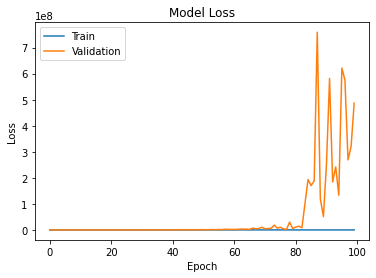

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_4_100.history['loss'])
plt.plot(history_4_100.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

This model is dirastically overfit as there is a huge gap in the scale of the loss between the training and validation data.
<hr>

In [ ]:
#checking the validation and train loss 
train_loss_3 = history_3.history['loss'][-1]
result_3 = model_3.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_3: .4f}')
print(f'Validation loss: {result_3: .4f}')

#scoring the model with R2
y_pred_4_100 = model_4.predict(X_validation_s)

r2_score(y_validation, y_pred_4_100)

Train loss:  526.8250
Validation loss:  982372.1875


-170058.24510475397

<hr>

This model did not respond well at all to running for more epochs. Given that the previous model trained on fewer epochs still exhibited overfitting, this architecture is not a good candidate for use as the final model. 
<hr>

## Model 5* - slimming the model more

<hr>

Since the last model fit so poorly, I decided to cut out more layers from the architecture to see if that would help. After two trials with poor performance with batch normalization I also decided that this method was not appropriate for this data and therefore left it out of subsequent models. 
<hr>

In [ ]:
#Model 5

#create a sequential model 
model_5 = keras.Sequential()

#creating hidden layers
model_5.add(layers.Dense(101, activation='relu'))
model_5.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_5.add(layers.Dense(87, activation='relu'))
model_5.add(layers.Dense(9, activation='relu'))

#declaring the output layer 
model_5.add(layers.Dense(1))

#compile the model 
model_5.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_5 = model_5.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 2ms/step - loss: 1913.5541 - val_loss: 1242.3759
Epoch 2/50
474/474 [==============================] - 1s 2ms/step - loss: 1264.3092 - val_loss: 1244.3671
Epoch 3/50
474/474 [==============================] - 1s 2ms/step - loss: 1119.1731 - val_loss: 1396.4392
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 1050.0344 - val_loss: 1305.1678
Epoch 5/50
474/474 [==============================] - 1s 2ms/step - loss: 997.9891 - val_loss: 2203.2307
Epoch 6/50
474/474 [==============================] - 1s 2ms/step - loss: 803.9672 - val_loss: 2103.6047
Epoch 7/50
474/474 [==============================] - 1s 2ms/step - loss: 827.5778 - val_loss: 1268.1321
Epoch 8/50
474/474 [==============================] - 2s 4ms/step - loss: 767.7682 - val_loss: 1477.3658
Epoch 9/50
474/474 [==============================] - 2s 4ms/step - loss: 730.4630 - val_loss: 1483.2489
Epoch 10/50
474/474 [==============================

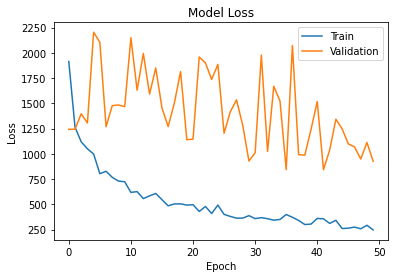

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

This model is not too overfit as the loss of the training and validation data at least fit on the same scale of axes. After 50 epochs it does appear that the validation loss is still going down, therefore, I thought it might be worth exploring using more epochs.
<hr>

In [ ]:
#checking the train and validation loss
train_loss_5 = history_5.history['loss'][-1]
result_5 = model_5.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_5: .4f}')
print(f'Validation loss: {result_5: .4f}')


Train loss:  247.4506
Validation loss:  926.6403


In [ ]:
#scoring the model with the R2
y_pred_5 = model_5.predict(X_validation_s)

r2_score(y_validation, y_pred_5)

0.6762019229831215

<hr>

This is the best scoring model thus far. Since it performed so well, I decided to go ahead and try running the model for 100 epochs with a early stop callback function with patience 10. 
<hr>

### Model 5 with 100 epochs

In [ ]:
#Model 5

#create a sequential model 
model_5 = keras.Sequential()

#creating hidden layers
model_5.add(layers.Dense(101, activation='relu'))
model_5.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_5.add(layers.Dense(87, activation='relu'))
model_5.add(layers.Dense(9, activation='relu'))

#declaring the output layer 
model_5.add(layers.Dense(1))

#compile the model 
model_5.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_5_100 = model_5.fit(X_train_s, y_train, epochs=100, verbose=1, validation_data=(X_validation_s, y_validation),
                            callbacks=[callback])

Epoch 1/100
474/474 [==============================] - 1s 2ms/step - loss: 1902.5779 - val_loss: 1218.8096
Epoch 2/100
474/474 [==============================] - 1s 2ms/step - loss: 1274.3647 - val_loss: 1233.8329
Epoch 3/100
474/474 [==============================] - 1s 2ms/step - loss: 1165.5802 - val_loss: 1341.8414
Epoch 4/100
474/474 [==============================] - 1s 2ms/step - loss: 1046.1748 - val_loss: 1202.2552
Epoch 5/100
474/474 [==============================] - 2s 5ms/step - loss: 1015.0224 - val_loss: 1913.6400
Epoch 6/100
474/474 [==============================] - 2s 4ms/step - loss: 827.3320 - val_loss: 2056.4663
Epoch 7/100
474/474 [==============================] - 2s 4ms/step - loss: 853.9185 - val_loss: 1263.4771
Epoch 8/100
474/474 [==============================] - 2s 4ms/step - loss: 743.5356 - val_loss: 1379.0974
Epoch 9/100
474/474 [==============================] - 2s 5ms/step - loss: 792.6517 - val_loss: 1443.9508
Epoch 10/100
474/474 [===================

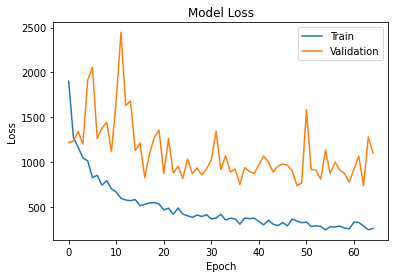

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_5_100.history['loss'])
plt.plot(history_5_100.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The validation loss ended up increasing at the end, so more epochs did not necessarily optimize the model. 
<hr>

In [ ]:
#checking the train and test loss
train_loss_5_100 = history_5_100.history['loss'][-1]
result_5_100 = model_5.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_5_100: .4f}')
print(f'Validation loss: {result_5_100: .4f}')

#scoring the model with the R2
y_pred_5_100 = model_5.predict(X_validation_s)

print(f'The R2 score: {r2_score(y_validation, y_pred_5_100)}')

Train loss:  261.4544
Validation loss:  1102.5156
The R2 score: 0.6147452033280697


<hr>

This model showed slightly lower performance than the previous model with 50 epochs, therefore, this is the better candidate for the final model. 
<hr>

## Model 6 - continuing to slim the model

<hr>

Along with the trend of slimming down from the architecture of model 2, I removed another layer to test if this would still yet improve model performance. 
<hr>

In [ ]:
#Model 6

#create a sequential model 
model_6 = keras.Sequential()

#creating hidden layers
model_6.add(layers.Dense(101, activation='relu'))
model_6.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_6.add(layers.Dense(87, activation='relu'))
model_6.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_6.add(layers.Dense(1))

#compile the model 
model_6.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_6 = model_6.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 2ms/step - loss: 2011.8490 - val_loss: 1216.8953
Epoch 2/50
474/474 [==============================] - 1s 2ms/step - loss: 1336.0809 - val_loss: 1244.8859
Epoch 3/50
474/474 [==============================] - 1s 2ms/step - loss: 1238.0021 - val_loss: 1377.2775
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 1128.5226 - val_loss: 1260.3397
Epoch 5/50
474/474 [==============================] - 1s 2ms/step - loss: 1083.1509 - val_loss: 1677.0803
Epoch 6/50
474/474 [==============================] - 1s 2ms/step - loss: 937.7993 - val_loss: 1698.5958
Epoch 7/50
474/474 [==============================] - 1s 2ms/step - loss: 1002.2487 - val_loss: 1345.6208
Epoch 8/50
474/474 [==============================] - 1s 2ms/step - loss: 901.0283 - val_loss: 1493.6488
Epoch 9/50
474/474 [==============================] - 1s 2ms/step - loss: 884.7903 - val_loss: 1494.9066
Epoch 10/50
474/474 [============================

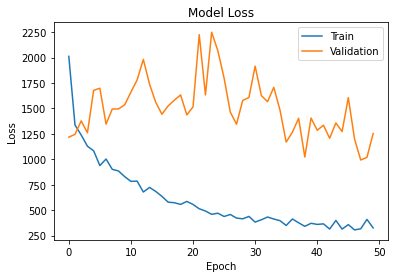

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The longer this model ran, the training and validation losses did not converge, suggesting that this model did not perform well. 
<hr>

In [ ]:
#checking the train and validation loss
train_loss_6 = history_6.history['loss'][-1]
result_6 = model_6.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_6: .4f}')
print(f'Validation loss: {result_6: .4f}')


Train loss:  324.8877
Validation loss:  1252.5063


In [ ]:
#scoring the model with an R2
y_pred_6 = model_6.predict(X_validation_s)

r2_score(y_validation, y_pred_6)

0.5623336729508461

<hr>

Though this model appeared to be quite overfit, the R2 was actually rather good. I kept this in mind moving forward with model selection. 
<hr>

## Model 7 - changing layer architecture

<hr>

At this point I was mainly just taking out layers from the model one-by-one. I then wanted to test how the data would respond to reordering the layers as well as adding and removing them. 
<hr>

In [ ]:
#Model 7

#create a sequential model 
model_7 = keras.Sequential()

#creating hidden layers
model_7.add(layers.Dense(101, activation='relu'))
model_7.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_7.add(layers.Dense(9, activation='relu'))

#declaring the output layer 
model_7.add(layers.Dense(1))

#compile the model 
model_7.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_7 = model_7.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 3s 5ms/step - loss: 2416.2747 - val_loss: 1331.2478
Epoch 2/50
474/474 [==============================] - 2s 4ms/step - loss: 1451.1681 - val_loss: 1229.5219
Epoch 3/50
474/474 [==============================] - 2s 3ms/step - loss: 1291.9398 - val_loss: 1289.4728
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 1202.2004 - val_loss: 1257.2712
Epoch 5/50
474/474 [==============================] - 1s 2ms/step - loss: 1213.6421 - val_loss: 1464.9474
Epoch 6/50
474/474 [==============================] - 2s 4ms/step - loss: 1075.4244 - val_loss: 1541.9684
Epoch 7/50
474/474 [==============================] - 2s 3ms/step - loss: 1082.9883 - val_loss: 1365.2571
Epoch 8/50
474/474 [==============================] - 1s 2ms/step - loss: 1023.5554 - val_loss: 1409.1290
Epoch 9/50
474/474 [==============================] - 1s 2ms/step - loss: 981.6589 - val_loss: 1410.8142
Epoch 10/50
474/474 [==========================

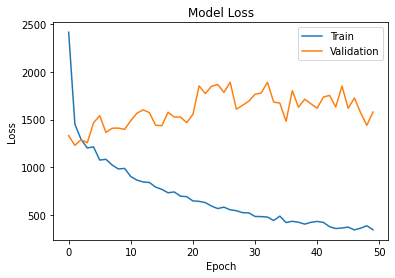

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

There was quite the divergence here in train and validation loss, definitely suggesting that this model was overfit.
<hr>

In [ ]:
#checking the train and validation loss
train_loss_7 = history_7.history['loss'][-1]
result_7 = model_7.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_7: .4f}')
print(f'Validation loss: {result_7: .4f}')


Train loss:  343.7906
Validation loss:  1579.3329


In [ ]:
#scoring the model with an R2 test
y_pred_7 = model_7.predict(X_validation_s)

r2_score(y_validation,y_pred_7)

0.44812991534463087

<hr>

Due to this model being overfit and scoring 0.45 for its r-score, worse than other models, there is no need to keep this model under consideration.
<hr>

## Model 8* - reordering and adding more dropout layers

<hr>

In addition to reordering the layers, I tested to see how the model would react to having more dropout layers, as well as having a dropour after the layer with just 9 nodes. 
<hr>

In [ ]:
#Model 8

#create a sequential model 
model_8 = keras.Sequential()

#creating hidden layers
model_8.add(layers.Dense(101, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_8.add(layers.Dense(87, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))
model_8.add(layers.Dense(9, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))
model_8.add(layers.Dense(92, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_8.add(layers.Dense(1))

#compile the model 
model_8.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_8 = model_8.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 3ms/step - loss: 2044.1118 - val_loss: 1248.3051
Epoch 2/50
474/474 [==============================] - 1s 3ms/step - loss: 1512.1970 - val_loss: 1187.1498
Epoch 3/50
474/474 [==============================] - 1s 3ms/step - loss: 1320.6365 - val_loss: 1369.9753
Epoch 4/50
474/474 [==============================] - 1s 3ms/step - loss: 1216.6669 - val_loss: 1235.3828
Epoch 5/50
474/474 [==============================] - 1s 3ms/step - loss: 1147.7915 - val_loss: 1819.9017
Epoch 6/50
474/474 [==============================] - 1s 2ms/step - loss: 1055.9373 - val_loss: 1975.9174
Epoch 7/50
474/474 [==============================] - 1s 3ms/step - loss: 962.0607 - val_loss: 1275.9370
Epoch 8/50
474/474 [==============================] - 1s 3ms/step - loss: 864.1329 - val_loss: 1398.3904
Epoch 9/50
474/474 [==============================] - 2s 5ms/step - loss: 702.6661 - val_loss: 1210.8669
Epoch 10/50
474/474 [============================

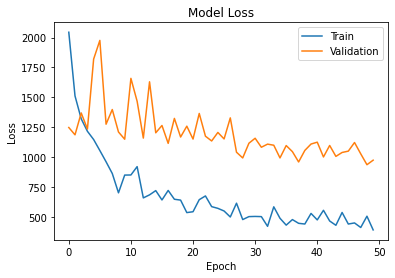

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_8.history['loss'])
plt.plot(history_8.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

While the train and validation loss did not necessarily converge, the gap between the two is not so large to cause concern. 
<hr>

In [ ]:
#checking the train and validation loss
train_loss_8 = history_8.history['loss'][-1]
result_8 = model_8.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_8: .4f}')
print(f'Validation loss: {result_8: .4f}')


Train loss:  392.7676
Validation loss:  975.3824


In [ ]:
#scoring the model with R2
y_pred_8 = model_8.predict(X_validation_s)

r2_score(y_validation, y_pred_8)

0.6591697299101482

<hr>

This model performed very well. Since it's accuracy of an r2 score of 0.66 was close to the accuracy of model 5, the best model thus far, and the train and validation loss did not diverge, I decided to test it with more epochs, setting it to 100 with a stop early callback with a patience threshold of 10 to see if that would improve the accuracy.
<hr>

### Model 8 with 100 epochs

In [ ]:
#Model 8

#create a sequential model 
model_8 = keras.Sequential()

#creating hidden layers
model_8.add(layers.Dense(101, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_8.add(layers.Dense(87, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))
model_8.add(layers.Dense(9, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))
model_8.add(layers.Dense(92, activation='relu'))
model_8.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_8.add(layers.Dense(1))

#compile the model 
model_8.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_8_100 = model_8.fit(X_train_s, y_train, epochs=100, verbose=1, validation_data=(X_validation_s, y_validation),
                            callbacks=[callback])

Epoch 1/100
474/474 [==============================] - 3s 5ms/step - loss: 2127.8894 - val_loss: 1237.7557
Epoch 2/100
474/474 [==============================] - 2s 5ms/step - loss: 1437.2871 - val_loss: 1178.7557
Epoch 3/100
474/474 [==============================] - 3s 6ms/step - loss: 1305.1705 - val_loss: 1337.4645
Epoch 4/100
474/474 [==============================] - 2s 5ms/step - loss: 1143.9558 - val_loss: 1222.3723
Epoch 5/100
474/474 [==============================] - 2s 4ms/step - loss: 1215.0026 - val_loss: 1487.1846
Epoch 6/100
474/474 [==============================] - 2s 5ms/step - loss: 1125.0569 - val_loss: 1672.9072
Epoch 7/100
474/474 [==============================] - 2s 4ms/step - loss: 938.3635 - val_loss: 1263.0120
Epoch 8/100
474/474 [==============================] - 2s 5ms/step - loss: 911.6599 - val_loss: 1539.5634
Epoch 9/100
474/474 [==============================] - 2s 5ms/step - loss: 787.8690 - val_loss: 1154.5267
Epoch 10/100
474/474 [==================

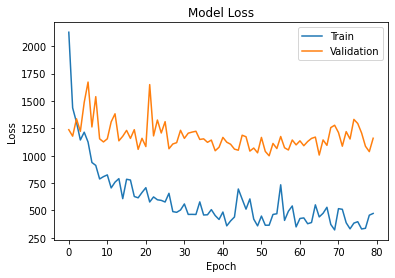

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_8_100.history['loss'])
plt.plot(history_8_100.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

This does show that there was a bit more divergence after 50 epochs, suggesting that there may be some overfitting. 
<hr>

In [ ]:
#checking the train and validation loss
train_loss_8_100 = history_8_100.history['loss'][-1]
result_8_100 = model_8.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_8_100: .4f}')
print(f'Validation loss: {result_8_100: .4f}')

Train loss:  472.8718
Validation loss:  1159.7770


In [ ]:
#scoring the model with R2
y_pred_8_100 = model_8.predict(X_validation_s)

r2_score(y_validation,y_pred_8_100)

0.594736206577334

<hr>

The model had an r2 of 0.59, not better than when it ran for 50 epochs, therefore I moved forward with testing the 50 epoch model for best accuracy compared to the other well performing models. 
<hr>

## Model 9 - reordering the layers and starting with a dropout

<hr>

Since none of the other models started with a dropout layer, I decided to explore that with this model where I again reordered the layers with different numbers of nodes. 
<hr>

In [ ]:
#Model 9

#create a sequential model 
model_9 = keras.Sequential()

#creating hidden layers
model_9.add(layers.Dropout(rate=0.25))
model_9.add(layers.Dense(87, activation='relu'))
model_9.add(layers.Dropout(rate=0.25))
model_9.add(layers.Dense(9, activation='relu'))

model_9.add(layers.Dense(101, activation='relu'))
model_9.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_9.add(layers.Dense(1))

#compile the model 
model_9.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_9 = model_9.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 3ms/step - loss: 2294.4751 - val_loss: 1280.4933
Epoch 2/50
474/474 [==============================] - 1s 2ms/step - loss: 1612.1085 - val_loss: 1230.2825
Epoch 3/50
474/474 [==============================] - 1s 2ms/step - loss: 1504.9730 - val_loss: 1313.1974
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 1428.5167 - val_loss: 1276.6082
Epoch 5/50
474/474 [==============================] - 1s 2ms/step - loss: 1546.4973 - val_loss: 1277.0583
Epoch 6/50
474/474 [==============================] - 1s 2ms/step - loss: 1226.4778 - val_loss: 1583.4185
Epoch 7/50
474/474 [==============================] - 2s 4ms/step - loss: 1406.4283 - val_loss: 1295.4644
Epoch 8/50
474/474 [==============================] - 2s 4ms/step - loss: 1336.8744 - val_loss: 1321.9969
Epoch 9/50
474/474 [==============================] - 3s 6ms/step - loss: 1201.7427 - val_loss: 1269.1854
Epoch 10/50
474/474 [=========================

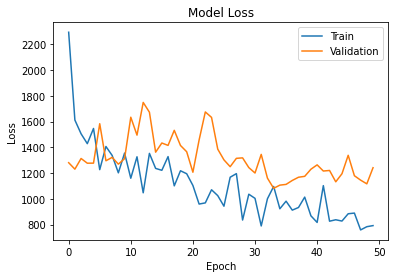

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_9.history['loss'])
plt.plot(history_9.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

This plot looked pretty good. It looked like the optimal number of epochs would be around 30, however, as that was where the validation loss was lowest and there was little difference with the training loss. Overall though, this model appeared to not be very overfit.
<hr>

In [ ]:
#checking the validation and train loss
train_loss_9 = history_9.history['loss'][-1]
result_9 = model_9.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_9: .4f}')
print(f'Validation loss: {result_9: .4f}')


Train loss:  791.5456
Validation loss:  1241.4714


In [ ]:
#scoring the model with the R2 score
y_pred_9 = model_9.predict(X_validation_s)

r2_score(y_validation, y_pred_9)

0.566189537558687

<hr>

While this model did not show to be concerningly overfit, its r2 of 0.57 was not as good as others, and was therefore not considered further for model selection. 
<hr>

## Model 10 - reordering layers without starting with a dropout

<hr>

I wanted to change the order again, this time having a smaller layer wiht just 9 nodes to start. I also removed the dropout layer at the beginning as I felt that it didn't make a large improvement to the model.
<hr>

In [ ]:
#Model 10
#create a sequential model 
model_10 = keras.Sequential()

#creating hidden layers
model_10.add(layers.Dense(9, activation='relu'))
model_10.add(layers.Dense(87, activation='relu'))
model_10.add(layers.Dropout(rate=0.25))
model_10.add(layers.Dense(101, activation='relu'))
model_10.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_10.add(layers.Dense(1))

#compile the model 
model_10.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_10 = model_10.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 2ms/step - loss: 2170.8772 - val_loss: 1324.1080
Epoch 2/50
474/474 [==============================] - 1s 2ms/step - loss: 1507.5364 - val_loss: 1327.8179
Epoch 3/50
474/474 [==============================] - 1s 2ms/step - loss: 1370.3275 - val_loss: 1387.6150
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 1273.7101 - val_loss: 1318.6886
Epoch 5/50
474/474 [==============================] - 1s 2ms/step - loss: 1229.7015 - val_loss: 1771.3514
Epoch 6/50
474/474 [==============================] - 1s 2ms/step - loss: 1180.3141 - val_loss: 1739.0294
Epoch 7/50
474/474 [==============================] - 1s 2ms/step - loss: 1133.7349 - val_loss: 1356.5508
Epoch 8/50
474/474 [==============================] - 1s 2ms/step - loss: 1054.6090 - val_loss: 1576.0109
Epoch 9/50
474/474 [==============================] - 1s 2ms/step - loss: 1069.3384 - val_loss: 1551.3469
Epoch 10/50
474/474 [=========================

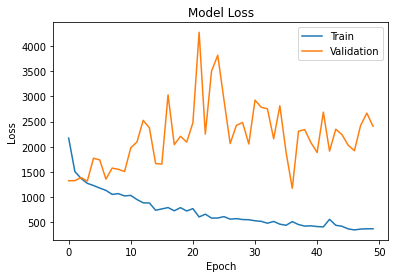

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The train and validation loss looks to diverge pretty significantly, suggesting that this model is overfit and not a good candidate. 
<hr>

In [ ]:
#checking the validation and train loss
train_loss_10 = history_10.history['loss'][-1]
result_10 = model_10.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_10: .4f}')
print(f'Validation loss: {result_10: .4f}')


Train loss:  371.7568
Validation loss:  2405.5645


In [ ]:
#scoring the model with the R2 score
y_pred_10 = model_10.predict(X_validation_s)

r2_score(y_validation, y_pred_10)

0.1594180311511042

<hr>

The r2 score of 0.15 is one of the worst that I saw so far in the model building process, therefore, this model was not considered for final model selection. 
<hr>

## Model 11 - removing the layer with 101 nodes

## Model 12* - sandwiching with 101 node layers 

<hr>

To try another architecture scheme, I added a layer with 101 nodes at the beginning and the end of the hidden layer. 
<hr>

In [ ]:
#Model 12

#create a sequential model 
model_12 = keras.Sequential()

#creating hidden layers
model_12.add(layers.Dense(101, activation='relu'))
model_12.add(layers.Dropout(rate=0.20))

#layers of the number of different feature types
model_12.add(layers.Dense(87, activation='relu'))
model_12.add(layers.Dense(9, activation='relu'))
model_12.add(layers.Dense(101, activation='relu'))
model_12.add(layers.Dropout(rate=0.20))

#declaring the output layer 
model_12.add(layers.Dense(1))

#compile the model 
model_12.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_12 = model_12.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 3ms/step - loss: 1931.0897 - val_loss: 1212.3628
Epoch 2/50
474/474 [==============================] - 1s 3ms/step - loss: 1271.0704 - val_loss: 1242.6483
Epoch 3/50
474/474 [==============================] - 1s 2ms/step - loss: 1137.8925 - val_loss: 1361.4532
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 1022.5904 - val_loss: 1326.7847
Epoch 5/50
474/474 [==============================] - 1s 2ms/step - loss: 1000.1245 - val_loss: 3172.2029
Epoch 6/50
474/474 [==============================] - 1s 2ms/step - loss: 877.0519 - val_loss: 2835.8428
Epoch 7/50
474/474 [==============================] - 1s 3ms/step - loss: 749.3051 - val_loss: 1288.4124
Epoch 8/50
474/474 [==============================] - 1s 3ms/step - loss: 736.0330 - val_loss: 1273.9941
Epoch 9/50
474/474 [==============================] - 1s 3ms/step - loss: 684.1517 - val_loss: 1585.0111
Epoch 10/50
474/474 [=============================

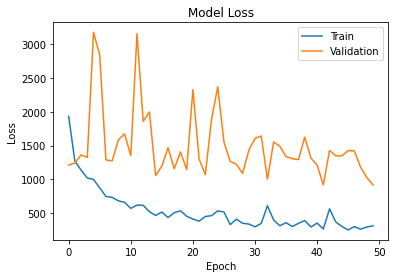

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_12.history['loss'])
plt.plot(history_12.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

While the training and validation loss did not perfectly converge, they appeared to reduce at the same rate and did not end with such great differences. This suggested perhaps that the model might perform even better with more epochs.
<hr>

In [ ]:
#checking the validation and train loss
train_loss_12 = history_12.history['loss'][-1]
result_12 = model_12.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_12: .4f}')
print(f'Validation loss: {result_12: .4f}')


Train loss:  314.9274
Validation loss:  918.0528


In [ ]:
#scoring the model with the R2 score
y_pred_12 = model_12.predict(X_validation_s)

r2_score(y_validation, y_pred_12)

0.6792026738781627

<hr>

This model performed very well, and therefore was considered for final model selection. I decided to try running this model for more epochs to see if it would further improve the r2 score beyond 0.68.
<hr>

### Testing model 12 with 100 epochs with a callback

In [ ]:
#Model 12

#create a sequential model 
model_12 = keras.Sequential()

#creating hidden layers
model_12.add(layers.Dense(101, activation='relu'))
model_12.add(layers.Dropout(rate=0.20))

#layers of the number of different feature types
model_12.add(layers.Dense(87, activation='relu'))
model_12.add(layers.Dense(9, activation='relu'))
model_12.add(layers.Dense(101, activation='relu'))
model_12.add(layers.Dropout(rate=0.20))

#declaring the output layer 
model_12.add(layers.Dense(1))

#compile the model 
model_12.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_12_1000 = model_12.fit(X_train_s, y_train, epochs=100, verbose=1, validation_data=(X_validation_s, y_validation),
                            callbacks=[callback])

Epoch 1/100
474/474 [==============================] - 4s 6ms/step - loss: 1900.3267 - val_loss: 1224.1437
Epoch 2/100
474/474 [==============================] - 2s 5ms/step - loss: 1334.3490 - val_loss: 1275.7587
Epoch 3/100
474/474 [==============================] - 2s 5ms/step - loss: 1239.5933 - val_loss: 1451.1791
Epoch 4/100
474/474 [==============================] - 3s 6ms/step - loss: 1048.0398 - val_loss: 1334.0004
Epoch 5/100
474/474 [==============================] - 2s 4ms/step - loss: 880.0773 - val_loss: 2991.3032
Epoch 6/100
474/474 [==============================] - 3s 6ms/step - loss: 753.6405 - val_loss: 2898.4915
Epoch 7/100
474/474 [==============================] - 3s 7ms/step - loss: 799.2653 - val_loss: 1245.4133
Epoch 8/100
474/474 [==============================] - 4s 8ms/step - loss: 722.2575 - val_loss: 1932.5718
Epoch 9/100
474/474 [==============================] - 4s 8ms/step - loss: 864.7353 - val_loss: 1593.3545
Epoch 10/100
474/474 [====================

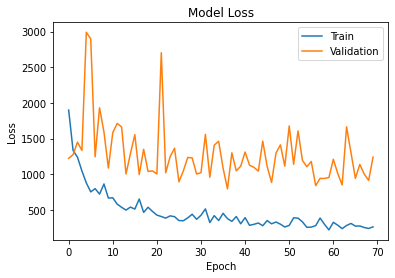

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_12_1000.history['loss'])
plt.plot(history_12_1000.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

It looks like there is a bit more loss and divergence at the end of this training, however, this is expected with a callback that is somewhat large such as 10. 
<hr>

In [ ]:
#checking the validation and train loss
train_loss_12_1000 = history_12_1000.history['loss'][-1]
result_12_1000 = model_12.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_12_1000: .4f}')
print(f'Validation loss: {result_12_1000: .4f}')

Train loss:  263.4650
Validation loss:  1240.1418


In [ ]:
#scoring the model with the R2 score
y_pred_12_1000 = model_12.predict(X_validation_s)

r2_score(y_validation,y_pred_12_1000)

0.5666539110213682

<hr>

This model did not perform better with more epochs as the r2 score is around .57, therefore, only the model run for 50 epochs will be considered for model selection. 
<hr>

## Model 13 - another 101 node layer sandwich

<hr>

As the above worked so well, I decided to do another model where I included another 5 node layer with a 101 node layer sandwich.
<hr>

In [ ]:
#Model 13

#create a sequential model 
model_13 = keras.Sequential()

#creating hidden layers
model_13.add(layers.Dense(101, activation='relu'))
model_13.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_13.add(layers.Dense(87, activation='relu'))
model_13.add(layers.Dropout(rate=0.25))
model_13.add(layers.Dense(9, activation='relu'))
model_13.add(layers.Dense(5, activation='relu'))
model_13.add(layers.Dense(101, activation='relu'))
model_13.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_13.add(layers.Dense(1))

#compile the model 
model_13.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_13 = model_13.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 2s 4ms/step - loss: 1960.7209 - val_loss: 1218.9999
Epoch 2/50
474/474 [==============================] - 1s 3ms/step - loss: 1375.4407 - val_loss: 1197.8945
Epoch 3/50
474/474 [==============================] - 1s 3ms/step - loss: 1230.4678 - val_loss: 1460.0063
Epoch 4/50
474/474 [==============================] - 1s 3ms/step - loss: 1091.0111 - val_loss: 1221.1160
Epoch 5/50
474/474 [==============================] - 2s 5ms/step - loss: 1011.9485 - val_loss: 2472.6292
Epoch 6/50
474/474 [==============================] - 3s 7ms/step - loss: 892.0627 - val_loss: 3325.1951
Epoch 7/50
474/474 [==============================] - 3s 7ms/step - loss: 867.3896 - val_loss: 1274.6488
Epoch 8/50
474/474 [==============================] - 3s 6ms/step - loss: 912.0096 - val_loss: 1855.0522
Epoch 9/50
474/474 [==============================] - 3s 7ms/step - loss: 692.8547 - val_loss: 1596.7448
Epoch 10/50
474/474 [=============================

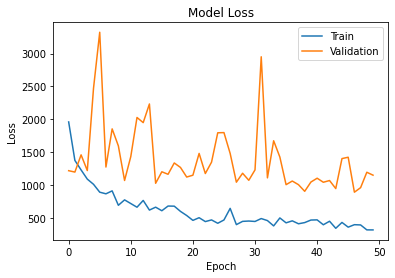

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_13.history['loss'])
plt.plot(history_13.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The trend of the validation loss is negative and is not diverging from the trend of the train data. Might be curious what more epochs would do. 
<hr>

In [ ]:
#checking the validation and train loss
train_loss_13 = history_13.history['loss'][-1]
result_13 = model_13.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_13: .4f}')
print(f'Validation loss: {result_13: .4f}')

Train loss:  318.0771
Validation loss:  1150.7129


In [ ]:
#scoring the model with the R2 score
y_pred_13 = model_13.predict(X_validation_s)

r2_score(y_validation,y_pred_13)

0.5979036886405922

<hr>

While an accuracy of 0.60 is good, it isn't quite as high as other models, therefore, this model was not considered for model selection. 
<hr>

### Model 13* with 80 epochs

In [ ]:
#Model 13

#create a sequential model 
model_13 = keras.Sequential()

#creating hidden layers
model_13.add(layers.Dense(101, activation='relu'))
model_13.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_13.add(layers.Dense(87, activation='relu'))
model_13.add(layers.Dropout(rate=0.25))
model_13.add(layers.Dense(9, activation='relu'))
model_13.add(layers.Dense(5, activation='relu'))
model_13.add(layers.Dense(101, activation='relu'))
model_13.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_13.add(layers.Dense(1))

#compile the model 
model_13.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_13_80 = model_13.fit(X_train_s, y_train, epochs=80, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/80
474/474 [==============================] - 4s 6ms/step - loss: 2014.7443 - val_loss: 1223.3816
Epoch 2/80
474/474 [==============================] - 3s 6ms/step - loss: 1312.0652 - val_loss: 1257.5914
Epoch 3/80
474/474 [==============================] - 3s 6ms/step - loss: 1198.1653 - val_loss: 1334.2524
Epoch 4/80
474/474 [==============================] - 4s 9ms/step - loss: 1154.7412 - val_loss: 1247.0977
Epoch 5/80
474/474 [==============================] - 3s 7ms/step - loss: 975.6686 - val_loss: 2625.6118
Epoch 6/80
474/474 [==============================] - 3s 7ms/step - loss: 880.8138 - val_loss: 2380.8237
Epoch 7/80
474/474 [==============================] - 3s 6ms/step - loss: 862.4068 - val_loss: 1213.3490
Epoch 8/80
474/474 [==============================] - 3s 7ms/step - loss: 874.3555 - val_loss: 1615.7778
Epoch 9/80
474/474 [==============================] - 3s 7ms/step - loss: 747.3055 - val_loss: 1124.9084
Epoch 10/80
474/474 [==============================

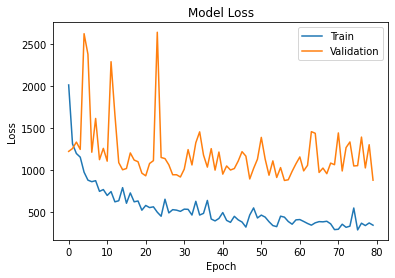

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_13_80.history['loss'])
plt.plot(history_13_80.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

There definitely isn't more overfitting, so this didn't necessarily hurt that. 
<hr>

In [ ]:
#checking the validation and train loss
train_loss_13_80 = history_13_80.history['loss'][-1]
result_13_80 = model_13.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_13_80: .4f}')
print(f'Validation loss: {result_13_80: .4f}')

Train loss:  344.0893
Validation loss:  880.3419


In [ ]:
#scoring the model with the R2 score
y_pred_13_80 = model_13.predict(X_validation_s)

r2_score(y_validation,y_pred_13_80)

0.6923799980448822

<hr>

With and R2 of around 0.69, this model showed really impressive accuracy with 80 epochs, and was therefore considered for final model selection. A callback function and further epochs for this model were not considered as during the initial model building process I was not employing that method and this model showed such good performance with 80 epochs, I decided to keep it here.
<hr>

## Model 14 - final reordering of layers

<hr>

I decied to do one more reordering of layers, removing the 101 node sandwich. In truth I could have continued exploring the different ordering of layers within the sandwich as well as continuing to exploring different orders of the layers further, however, for the sake of time I decided to limit this exploration here. 
<hr>

In [ ]:
#Building model 14

#create a sequential model 
model_14 = keras.Sequential()

#creating hidden layers
model_14.add(layers.Dense(101, activation='relu'))
model_14.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_14.add(layers.Dense(9, activation='relu'))
model_14.add(layers.Dense(87, activation='relu'))
model_14.add(layers.Dropout(rate=0.25))
model_14.add(layers.Dense(5, activation='relu'))

#declaring the output layer 
model_14.add(layers.Dense(1))

#compile the model 
model_14.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_14 = model_14.fit(X_train_s, y_train, epochs=50, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/50
474/474 [==============================] - 3s 5ms/step - loss: 2101.1711 - val_loss: 1235.3916
Epoch 2/50
474/474 [==============================] - 2s 4ms/step - loss: 1338.8063 - val_loss: 1280.2372
Epoch 3/50
474/474 [==============================] - 2s 5ms/step - loss: 1158.3082 - val_loss: 1480.2567
Epoch 4/50
474/474 [==============================] - 3s 6ms/step - loss: 1052.1980 - val_loss: 1278.7748
Epoch 5/50
474/474 [==============================] - 2s 5ms/step - loss: 989.3234 - val_loss: 2099.3169
Epoch 6/50
474/474 [==============================] - 2s 4ms/step - loss: 921.0837 - val_loss: 2039.2571
Epoch 7/50
474/474 [==============================] - 2s 4ms/step - loss: 840.0028 - val_loss: 1406.5406
Epoch 8/50
474/474 [==============================] - 3s 6ms/step - loss: 820.7308 - val_loss: 1486.1796
Epoch 9/50
474/474 [==============================] - 3s 6ms/step - loss: 704.1721 - val_loss: 1473.4774
Epoch 10/50
474/474 [==============================

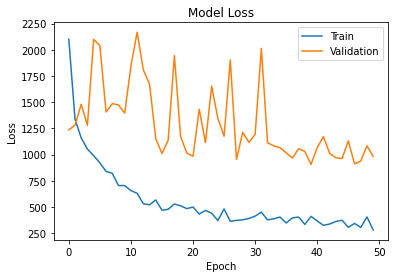

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_14.history['loss'])
plt.plot(history_14.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

There is rather a significant gap between the losses, however, the train and validation loss do not show divergence, so while it is a bit overfit, there isn't cause for major concern.
<hr>

In [ ]:
#checking the validation and train loss
train_loss_14 = history_14.history['loss'][-1]
result_14 = model_14.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_14: .4f}')
print(f'Validation loss: {result_14: .4f}')

Train loss:  280.8257
Validation loss:  981.1244


In [ ]:
#scoring the model with the R2 score
from sklearn.metrics import r2_score

y_pred_14 = model_14.predict(X_validation_s)

r2_score(y_validation,y_pred_14)

0.6571632560641112

<hr>

This model having and R2 of 0.66, makes it eligible for final model selection. Since model 13 performed so well with 80 epochs, I decided to test that again to see if I could improve this performance further. 
<hr>

### Model 14* with 80 epochs

In [ ]:
#Model 14

#create a sequential model 
model_14 = keras.Sequential()

#creating hidden layers
model_14.add(layers.Dense(101, activation='relu'))
model_14.add(layers.Dropout(rate=0.25))

#layers of the number of different feature types
model_14.add(layers.Dense(9, activation='relu'))
model_14.add(layers.Dense(87, activation='relu'))
model_14.add(layers.Dropout(rate=0.25))
model_14.add(layers.Dense(5, activation='relu'))

#declaring the output layer 
model_14.add(layers.Dense(1))

#compile the model 
model_14.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_14_80 = model_14.fit(X_train_s, y_train, epochs=80, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/80
474/474 [==============================] - 3s 5ms/step - loss: 1986.9537 - val_loss: 1250.7804
Epoch 2/80
474/474 [==============================] - 3s 6ms/step - loss: 1357.6188 - val_loss: 1253.9833
Epoch 3/80
474/474 [==============================] - 3s 6ms/step - loss: 1177.6003 - val_loss: 1507.8004
Epoch 4/80
474/474 [==============================] - 3s 6ms/step - loss: 1055.0056 - val_loss: 1278.8833
Epoch 5/80
474/474 [==============================] - 3s 6ms/step - loss: 894.0042 - val_loss: 2319.1372
Epoch 6/80
474/474 [==============================] - 2s 5ms/step - loss: 835.6152 - val_loss: 2001.7485
Epoch 7/80
474/474 [==============================] - 2s 5ms/step - loss: 823.4779 - val_loss: 1352.1359
Epoch 8/80
474/474 [==============================] - 2s 5ms/step - loss: 767.6439 - val_loss: 1511.2750
Epoch 9/80
474/474 [==============================] - 2s 5ms/step - loss: 637.9825 - val_loss: 1273.0172
Epoch 10/80
474/474 [==============================

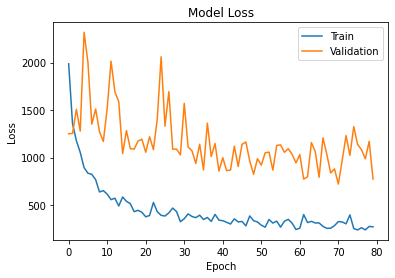

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_14_80.history['loss'])
plt.plot(history_14_80.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
#checking the validation and train loss
train_loss_14_80 = history_14_80.history['loss'][-1]
result_14_80 = model_14.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_14_80: .4f}')
print(f'Validation loss: {result_14_80: .4f}')

Train loss:  271.6265
Validation loss:  774.2669


In [ ]:
#scoring the model with the R2 score
from sklearn.metrics import r2_score

y_pred_14_80 = model_14.predict(X_validation_s)

r2_score(y_validation,y_pred_14_80)

0.729446063020907

<hr>

Using more epochs definitely improved the model a lot. This will be used in the final model selection analysis.
<hr>

# Conclusions 

<hr>

In this notebook I performed a gird search of a Decision Tree Regressor, Ridge Regression, and a Support Vector Regression. As the Decision Tree Regressor performed the best in this analysis, I decided to test a Random Forest Regressor. This model performed the best of the supervised learning models with and accuracy score 0.84. This model was pickled for potential future use.

I then tested 14 different architectures of neural networks. I evaluated these using and R2 score and evaluating loss trends to test for overfitting. I chose the 5 best models based on if thier R2 scores were above 0.65, a threshold I set after running the first few models. 

In the next notebook, notebook 04-CryptoPunk Price Prediction Model Selection and Implementation, I compared the top 5 neural networks, running each 15 times and looking at the mean accuracy scores and variances to select the best one. 

I then compared accuracies of the random forest model with the best neural network, testing both on data on recent CryptoPunk sales that are not included in the original dataset. 

And finally I ran the best model on upcoming sale data to make actual predictions. 
<hr>

# Data Dictionary

* `txn_type`: In the final dataset, this feature is all "Sold." This was kept to ensure that only data on sales was being used in the analysis. This feature was always removed when building and running models. 
* `date`: The date of the sale. This feature was used during EDA but was removed for model building and running. 
* `source`: This specifies the source of the transaction data. This data was compiled from sales through Larva Labs, the creators of CryptoPunks, and Opensea, one of the largest NFT trading platforms. 
* `eth`: The price the CryptoPunk sold for in Ether, the native cryptocurrency to the Ethereum blockchain. 
* `punk_id`: The unique ID of a CryptoPunk denotes the order it was minted in.
* `close`: The closing price of ETH in USD for the date of the sale. 
* `bid_count`: The number of bids made on the punk prior to the final sale.
* `mean_bid`: The average of the bids for the sale in ETH.
* `num_prev_sales`: The number of sales of the punk prior to that sale.
* `prev_price`: The price the punk sold for in ETH at the sale immediately prior. 
* `days_since_claim`: The number of days from the date CryptoPunks were first claimed (June 23, 2017) until the day of the sale.
* `whale_buy`: 1 if the buyer had made 100 or more purchases, 0 if the buyer had made fewer than 100 purchases.
* `whale_sell`: 1 if the seller had sold 100 or more times, 0 if the seller had sold for fewer than 100 times. 
* Traits vectors: Columns representing the unique traits found in CryptoPunks. 1 if the punk being sold has that trait, else 0.
* Types vectors: Columns representing the unique types of punks. 1 if the punk is that type, else 0.
* `punk_rarity`: A dervived variable to represent how common the traits and type of the punk is from 0-1, with a higher value denoting greater rarity. 
* Source vectors: `larvalabs` and `opensea` columns with 1 denoting the data on the sale came from that platform, else 0. 

# Appendix - Run of model from Keras Tuner
03.1 - Building tuner - Appendix

<hr>

The parameters in the following model came from the hyperparameter tuning method from Keras tuner.
<hr>

In [ ]:
#Tuner model

#create a sequential model 
model_tune = keras.Sequential()

#creating hidden layers
model_tune.add(layers.Dense(55, activation='relu'))
model_tune.add(layers.Dropout(rate=0.25))

#declaring the output layer 
model_tune.add(layers.Dense(1))

#specifying learning rate
learning_rate=0.4925

#compile the model 
model_tune.compile(
            #Optimizer
            optimizer=keras.optimizers.Adam(),
            #loss function to minimize - MSE is typically the best for regression networks
            loss=keras.losses.MeanSquaredError()
)

In [ ]:
#running model 
history_tune = model_tune.fit(X_train_s, y_train, epochs=100, verbose=1, validation_data=(X_validation_s, y_validation))

Epoch 1/100
474/474 [==============================] - 2s 2ms/step - loss: 3104.8250 - val_loss: 1957.1697
Epoch 2/100
474/474 [==============================] - 1s 2ms/step - loss: 1941.6896 - val_loss: 1411.5977
Epoch 3/100
474/474 [==============================] - 1s 2ms/step - loss: 1640.7288 - val_loss: 1239.9136
Epoch 4/100
474/474 [==============================] - 1s 2ms/step - loss: 1514.6466 - val_loss: 1181.4362
Epoch 5/100
474/474 [==============================] - 2s 4ms/step - loss: 1459.5603 - val_loss: 1171.4708
Epoch 6/100
474/474 [==============================] - 2s 4ms/step - loss: 1402.2924 - val_loss: 1188.0105
Epoch 7/100
474/474 [==============================] - 2s 3ms/step - loss: 1381.3607 - val_loss: 1186.9159
Epoch 8/100
474/474 [==============================] - 2s 4ms/step - loss: 1304.7058 - val_loss: 1201.6703
Epoch 9/100
474/474 [==============================] - 2s 4ms/step - loss: 1255.4510 - val_loss: 1213.9773
Epoch 10/100
474/474 [===============

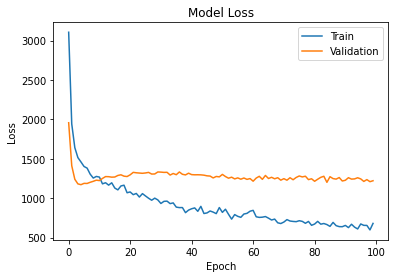

In [ ]:
#plot to see how the loss has responded to epochs 
plt.plot(history_tune.history['loss'])
plt.plot(history_tune.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

<hr>

The scale of the axes here indicate that there is a lot of overfitting of this model. Further, it shows that the validation loss never reduces, indicating further that the model is very overfit. 
<hr>

In [ ]:
#checking the validation and train loss
train_loss_tune = history_tune.history['loss'][-1]
result_tune = model_tune.evaluate(X_validation_s, y_validation, verbose=0)

print(f'Train loss: {train_loss_tune: .4f}')
print(f'Validation loss: {result_tune: .4f}')


Train loss:  680.2504
Validation loss:  1221.5688


In [ ]:
#scoring the model with the R2 score
y_pred_tune = model_tune.predict(X_validation_s)

r2_score(y_validation,y_pred_tune)

0.5731440882552359

<hr>

This model's R2 of around 0.57 is not an improvement on the other models. Further, it showed clear signs of over fitting. For these reasons I chose not to move forward with this model and to not continue to refine teh tuner due to the long run times and just focus on fine tuning my own model's architecture.  
<hr>